In [248]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Preparation

Data source: https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016


In [288]:
df = pd.read_csv('suicide_rates.csv',
    engine='python', decimal=',', thousands='.')#, parse_dates=['Date of Launch'], dayfirst=True)
df.columns

Index(['ï»¿country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [289]:
df = df.drop(columns=['HDI for year'], axis = 1)
df = df.rename(columns={'ï»¿country': 'country', ' gdp_for_year ($) ': 'gdp_for_year ($)' })

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   country             27820 non-null  object
 1   year                27820 non-null  int64 
 2   sex                 27820 non-null  object
 3   age                 27820 non-null  object
 4   suicides_no         27820 non-null  int64 
 5   population          27820 non-null  int64 
 6   suicides/100k pop   27820 non-null  int64 
 7   country-year        27820 non-null  object
 8   gdp_for_year ($)    27820 non-null  object
 9   gdp_per_capita ($)  27820 non-null  int64 
 10  generation          27820 non-null  object
dtypes: int64(5), object(6)
memory usage: 2.3+ MB


## Outliers

In [291]:
def outliers_iqr(df, feature): # Funkcija kurioje nurodomas data frame ir feature, kurio outlier norim panaikinti
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    outliers = ((df[[feature]] < (q1 - 1.5 * iqr)) |(df[[feature]] > (q3 + 1.5 * iqr))).any(axis=1)
    return outliers

## Evaluation metrics
- MAE: mean absolute error
- MSE: mean squared error
- RMSE: root mean squared error
- R2: coefficient of determination

In [292]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

def print_metrics(y_true, y_pred):
    print(f'MAE: {mean_absolute_error(y_true, y_pred)}')
    print(f'MSE: {mean_squared_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'R2: {r2_score(y_true, y_pred)}')

In [293]:
def plot_true_vs_pred(y_true, y_pred):
    plt.figure(figsize=(6, 4), dpi=100)
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_pred.max()], color='black', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

# Lithuanian Data 

In [294]:
Lietuva = df.query('country == "Lithuania"')

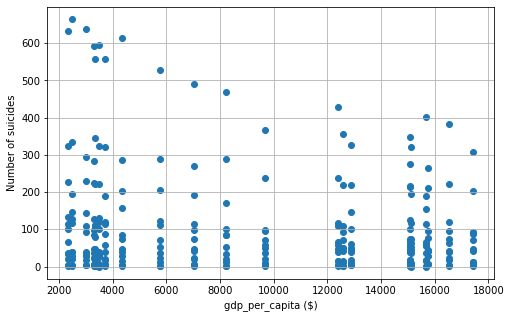

In [295]:
# With outliers
plt.figure(figsize=(8, 5))
plt.scatter(Lietuva['gdp_per_capita ($)'], Lietuva['suicides_no'])
plt.xlabel('gdp_per_capita ($)')
plt.ylabel('Number of suicides')
plt.grid()
plt.show()

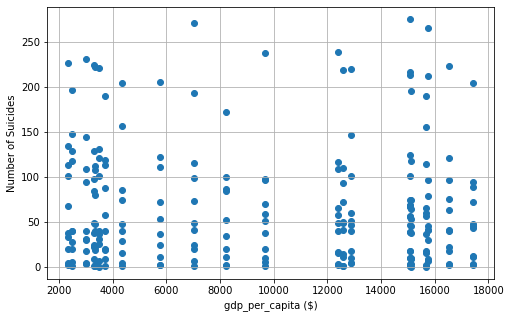

In [296]:
non_outliers = ~outliers_iqr(Lietuva, 'suicides_no')

plt.figure(figsize=(8, 5))
plt.scatter(Lietuva[non_outliers]['gdp_per_capita ($)'], Lietuva[non_outliers]['suicides_no'])
plt.xlabel('gdp_per_capita ($)')
plt.ylabel('Number of Suicides')
plt.grid()
plt.show()

## DIY Regression Algorithm

In [297]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = Lietuva[non_outliers]['gdp_per_capita ($)'].values.reshape(-1, 1)
y = Lietuva[non_outliers]['suicides_no'].values.reshape(-1, 1)
lr.fit(X, y)
#y_pred = lr.predict(X)

print('Training error:')
print_metrics(y, lr.predict(X))

print()
print('Model parameters:')
print(lr.coef_, lr.intercept_)

Training error:
MAE: 51.67515363896324
MSE: 4362.960317330334
RMSE: 66.05270862977788
R2: 0.0009462485441545931

Model parameters:
[[-0.00037532]] [69.83666017]


In [298]:
#X =Lietuva[non_outliers]['gdp_per_capita ($)'].values.reshape(-1, 1)
#Y =Lietuva[non_outliers]['suicides_no'].values.reshape(-1, 1)

In [299]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=73)

Gradient Descent Algorithm - Simple Linear Regression 

In [300]:
x_train_mean = np.mean(x_train)
y_train_mean = np.mean(y_train)
m = len(x_train)

temp_n = 0
temp_d = 0

for i in range(m):
    temp_n += (x_train[i] - x_train_mean)*(y_train[i]-y_train_mean)
    temp_d += (x_train[i] - x_train_mean)**2
    
w_1 = temp_n/temp_d
w_0 = y_train_mean - w_1*x_train_mean
print(w_0, w_1)

y_train_pred = w_0 + w_1*x_train

y_test_pred = w_0 + w_1*x_test



[66.86508085] [-0.00017164]


### Comparison with scikit learn

In [301]:
lr.fit(x_train, y_train)

LinearRegression()

In [302]:
print('Scikit learn:')
print(lr.intercept_, lr.coef_)
print('DIY Regression:')
print(w_0, w_1)

Scikit learn:
[66.86508085] [[-0.00017164]]
DIY Regression:
[66.86508085] [-0.00017164]


In [303]:
print('Scikit learn')
print_metrics(y_train, lr.predict(x_train))
print('\n')
print('DIY Regression')
print_metrics(y_train, y_train_pred)

Scikit learn
MAE: 50.860643388008725
MSE: 4312.197729756215
RMSE: 65.66732619618539
R2: 0.00020227345743195624


DIY Regression
MAE: 50.860643388008725
MSE: 4312.197729756215
RMSE: 65.66732619618539
R2: 0.00020227345743195624


Text(0, 0.5, 'Number of Suicides')

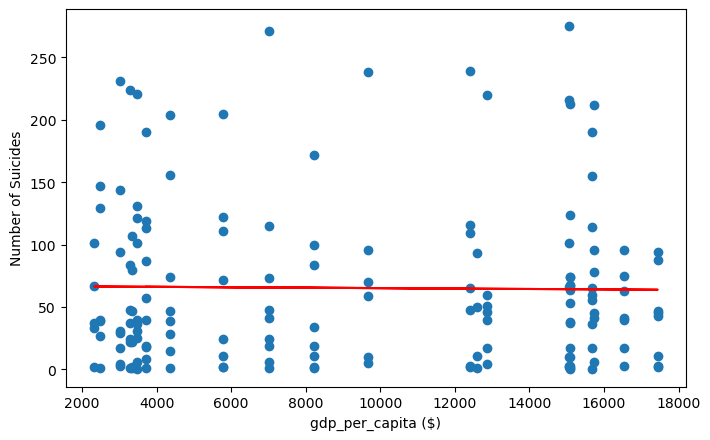

In [304]:
plt.figure(figsize=(8, 5), dpi=100)
plt.scatter(x_train, y_train)
plt.plot(x_train, y_train_pred, color='red')
plt.xlabel('gdp_per_capita ($)')
plt.ylabel('Number of Suicides')

## Model Evaluation 

3 different feature sets were chosen to the train regression model 

### Initial Moodel - Default proportions are 75% / 25%

In [312]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = Lietuva[non_outliers]['gdp_per_capita ($)'].values.reshape(-1, 1)
y = Lietuva[non_outliers]['suicides_no'].values.reshape(-1, 1)

train_idx, test_idx = train_test_split(range(len(X)), random_state=111)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model1 = LinearRegression()
model1.fit(X_train, y_train)

print('Training error:')
print_metrics(y_train, model1.predict(X_train))
print()
print('Test error:')
print_metrics(y_test, model1.predict(X_test))


Training error:
MAE: 51.886781309643055
MSE: 4330.017679004709
RMSE: 65.8028698386682
R2: 0.000937372715876239

Test error:
MAE: 50.926919992070026
MSE: 4461.8493940101225
RMSE: 66.79707623848608
R2: 0.0008056735913271051


### Polynomial features

In [309]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial features: 2nd degree
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_train2 = poly2.fit_transform(X_train)
X_test2 = poly2.transform(X_test)

# Normalize the data
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

# Train and evaluate the model
model2 = LinearRegression()
model2.fit(X_train2, y_train)

print('Training error:')
print_metrics(y_train, model2.predict(X_train2))
print()
print('Test error:')
print_metrics(y_test, model2.predict(X_test2))

Training error:
MAE: 51.74227946079718
MSE: 4291.390392623512
RMSE: 65.5087047087905
R2: 0.009849825522703193

Test error:
MAE: 51.38101415448364
MSE: 4691.549338041544
RMSE: 68.49488548819936
R2: -0.05063373204183974


### 70% / 30% Initial dataset partition

In [314]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=73)
model3 = LinearRegression()
model3.fit(x_train3, y_train3)
print('Training error:')
print_metrics(y_train3, model3.predict(x_train3))
print()
print('Test error:')
print_metrics(y_test3, model3.predict(x_test3))

Training error:
MAE: 50.860643388008725
MSE: 4312.197729756215
RMSE: 65.66732619618539
R2: 0.00020227345743195624

Test error:
MAE: 52.89748345131966
MSE: 4487.956098555299
RMSE: 66.99220923775614
R2: -0.0006481344490958385


### 60% / 40% Initial dataset partition

In [360]:
x_train4, x_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.4, random_state=73)
model4 = LinearRegression()
model4.fit(x_train4, y_train4)
print('Training error:')
print_metrics(y_train4, model4.predict(x_train4))
print()
print('Test error:')
print_metrics(y_test4, model4.predict(x_test4))

Training error:
MAE: 51.63632146054052
MSE: 4466.357525687318
RMSE: 66.83081269659466
R2: 0.0007481116199141713

Test error:
MAE: 51.176123057265166
MSE: 4211.07479805184
RMSE: 64.89279465435158
R2: -0.00018898762297658855


## K-fold cross validation

65.62829054063471
65.27301417527947
65.10591832378248
65.77733138675866


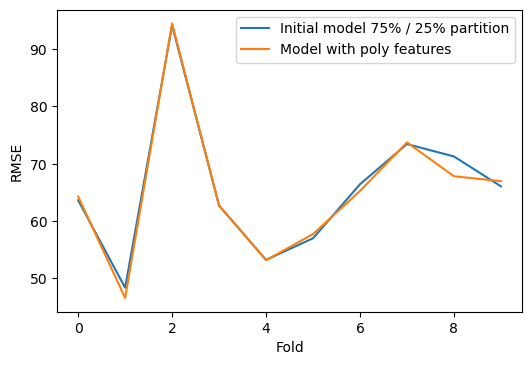

In [363]:
# Comparing multiple models by doing k-fold cross validation
from sklearn.model_selection import cross_val_score

def rmse(model, X, y):
    return np.sqrt(mean_squared_error(y, model.predict(X)))

scores1 = cross_val_score(model1, X_train, y_train, cv=10, scoring=rmse)
scores2 = cross_val_score(model2, X_train2, y_train, cv=10, scoring=rmse)
scores3 = cross_val_score(model3, x_train3, y_train3, cv=10, scoring=rmse)
scores4 = cross_val_score(model4, x_train4, y_train4, cv=10, scoring=rmse)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(scores1, label='Initial model 75% / 25% partition')
plt.plot(scores2, label='Model with poly features')
#plt.plot(scores3, label='Model with 70% / 30% partition')
#plt.plot(scores4, label='Model with 60% / 40% partition')

plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()

# Average scores:
print(scores1.mean())
print(scores2.mean())
print(scores3.mean())
print(scores4.mean())


# Regularization

### Overfiting model for Regularization

Degree: 1; Number of features: 1; RMSE(train) = 65.803; RMSE(test) = 66.797
Degree: 2; Number of features: 2; RMSE(train) = 65.509; RMSE(test) = 68.495
Degree: 3; Number of features: 3; RMSE(train) = 65.504; RMSE(test) = 68.473
Degree: 4; Number of features: 4; RMSE(train) = 65.345; RMSE(test) = 69.277


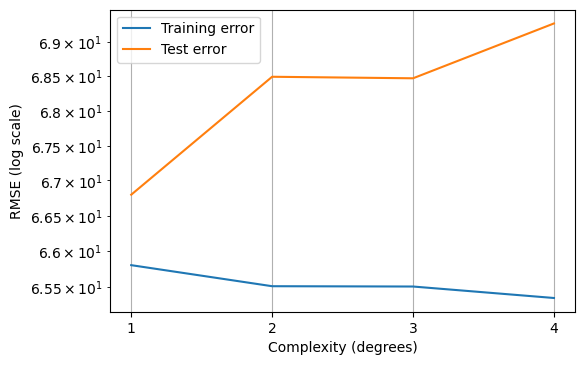

In [348]:
# Increasing degree of polynomial features
X = Lietuva[non_outliers]['gdp_per_capita ($)'].values.reshape(-1, 1)
y = Lietuva[non_outliers]['suicides_no'].values.reshape(-1, 1)

train_idx, test_idx = train_test_split(range(len(X)), random_state=111)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
train_errors, test_errors = [], []
degrees = list(range(1, 5))

for deg in degrees:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_train_p = poly.fit_transform(X_train)
    X_test_p = poly.fit_transform(X_test)

    model_p = LinearRegression()
    model_p.fit(X_train_p, y_train)
    
    # RMSE
    train_error = np.sqrt(mean_squared_error(y_train, model_p.predict(X_train_p)))
    test_error = np.sqrt(mean_squared_error(y_test, model_p.predict(X_test_p)))
    print(f'Degree: {deg}; Number of features: {poly.n_output_features_}; RMSE(train) = {train_error:.3f}; RMSE(test) = {test_error:.3f}')
    train_errors.append(train_error)
    test_errors.append(test_error)
    
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(train_errors, label='Training error')
plt.plot(test_errors, label='Test error')
plt.grid()
plt.xticks(range(0, 4), degrees)
plt.xlabel('Complexity (degrees)')
plt.ylabel('RMSE (log scale)')
plt.legend()
plt.yscale('log')
plt.show()

### WE found out that data overfits model with degree of polynomial features equal 4

## L2 Regularization

In [350]:
# Adding 4th degree polynomial features
poly4 = PolynomialFeatures(degree=4, include_bias=False)
X_train = poly4.fit_transform(X_train)
X_test = poly4.transform(X_test)
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [351]:
# Train and evaluate the model
model = LinearRegression()
model.fit(X_train, y_train)
print('Training error:')
print_metrics(y_train, model.predict(X_train))
print()
print('Test error:')
print_metrics(y_test, model.predict(X_test))

Training error:
MAE: 51.77103229473369
MSE: 4269.918371455174
RMSE: 65.34461241338244
R2: 0.01480405330462542

Test error:
MAE: 51.64433266102593
MSE: 4799.237311227607
RMSE: 69.27652785199044
R2: -0.07474956436339109


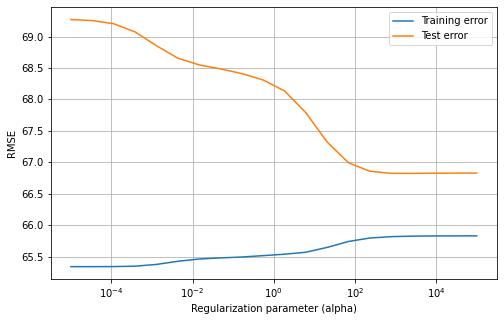

In [352]:
from sklearn.linear_model import Ridge

train_errors, test_errors = [], []
alphas = np.geomspace(1e-5, 1e5, 20)

for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    # RMSE
    train_error = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    test_error = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    train_errors.append(train_error)
    test_errors.append(test_error)
    
plt.figure(figsize=(8, 5))
plt.plot(alphas, train_errors, label='Training error')
plt.plot(alphas, test_errors, label='Test error')
plt.grid()
plt.xlabel('Regularization parameter (alpha)')
plt.ylabel('RMSE')
plt.legend()
plt.xscale('log')
plt.show()

In [353]:
# Check one model with particular alpha value
model_r = Ridge(alpha=1e-1)
model_r.fit(X_train, y_train)

print('Training error:')
print_metrics(y_train, model_r.predict(X_train))
print()
print('Test error:')
print_metrics(y_test, model_r.predict(X_test))

Training error:
MAE: 51.72241652347593
MSE: 4289.07480582678
RMSE: 65.49102843769352
R2: 0.010384099606632335

Test error:
MAE: 51.412371122461934
MSE: 4684.623803126911
RMSE: 68.44431169298812
R2: -0.04908281568788664


### The influence of Regularization on model

### *Before Regularization* 
Training error:
- MAE: 51.77103229473369
- MSE: 4269.918371455174
- RMSE: 65.34461241338244
- R2: 0.01480405330462542

Test error:
- MAE: 51.64433266102593
- **MSE: 4799.237311227607**
- **RMSE: 69.27652785199044**
- R2: -0.07474956436339109

### *After L2 Regularization* 
Training error:
- MAE: 51.72241652347593
- MSE: 4289.07480582678
- RMSE: 65.49102843769352
- R2: 0.010384099606632335

Test error:
- MAE: 51.412371122461934
- **MSE: 4684.623803126911**
- **RMSE: 68.44431169298812**
- R2: -0.04908281568788664


# Conclusions
1. Linear regression implementation was successful. The same results were get after performing regression with sci-kit learn library 
2. The model performed best with train/test data split to 60%/40%,  MSE = 4211.074, RMSE= 64.893
3. Increased degree of polynomial features leads to the model overfitting. 
4. In our case, model overfitting was reached with a degree of polynomial features equal to 4. 
5. A small improvement was noticed after overfitted model L2 regularization.  